In [1]:
import collect_env_details 
collect_env_details.main()

<details>
  <summary>Current environment</summary>

* CUDA:
	- GPU:
		- Quadro RTX 5000
	- available:         True
	- version:           11.8
* Lightning:
	- lightning-bolts:   0.7.0
	- lightning-utilities: 0.11.6
	- open-clip-torch:   2.26.1
	- pytorch-lightning: 1.9.5
	- pytorch-lightning-bolts: 0.3.2.post1
	- torch:             2.2.1
	- torchaudio:        2.2.1
	- torchmetrics:      1.4.1
	- torchvision:       0.17.1
* Packages:
	- absl-py:           2.1.0
	- accelerate:        0.33.0
	- aiofiles:          23.2.1
	- aiohappyeyeballs:  2.3.4
	- aiohttp:           3.10.1
	- aiosignal:         1.3.1
	- albucore:          0.0.13
	- albumentations:    1.4.13
	- annotated-types:   0.7.0
	- anyio:             4.4.0
	- asttokens:         2.4.1
	- astunparse:        1.6.3
	- async-timeout:     4.0.3
	- attrs:             24.1.0
	- bleach:            6.1.0
	- brotli:            1.0.9
	- certifi:           2024.7.4
	- charset-normalizer: 3.3.2
	- click:             8.1.7
	- colorama:          

In [5]:
import pytorch_lightning as pl
from torch import nn
import torch
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

In [6]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [7]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.')

In [9]:
pl.seed_everything(1234)
vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=15)
trainer.fit(vae, datamodule=datamodule)

Global seed set to 1234
C:\Users\1430647\AppData\Local\Temp\1\ipykernel_1068\3602030105.py:8: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
C:\Users\1430647\AppData\Local\Temp\1\ipykernel_1068\3602030105.py:9: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pytorch_lightning\trainer\connecto

100%|██████████| 170498071/170498071 [00:17<00:00, 9757023.48it/s] 


Extracting .\cifar-10-python.tar.gz to .
Files already downloaded and verified


Missing logger folder: c:\Users\1430647\My\workspace\pytorch-examples\examples\vae_modified\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = torch.rand(1, 3, 32, 32).to(device='cuda')

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

image shape: torch.Size([1, 3, 32, 32])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


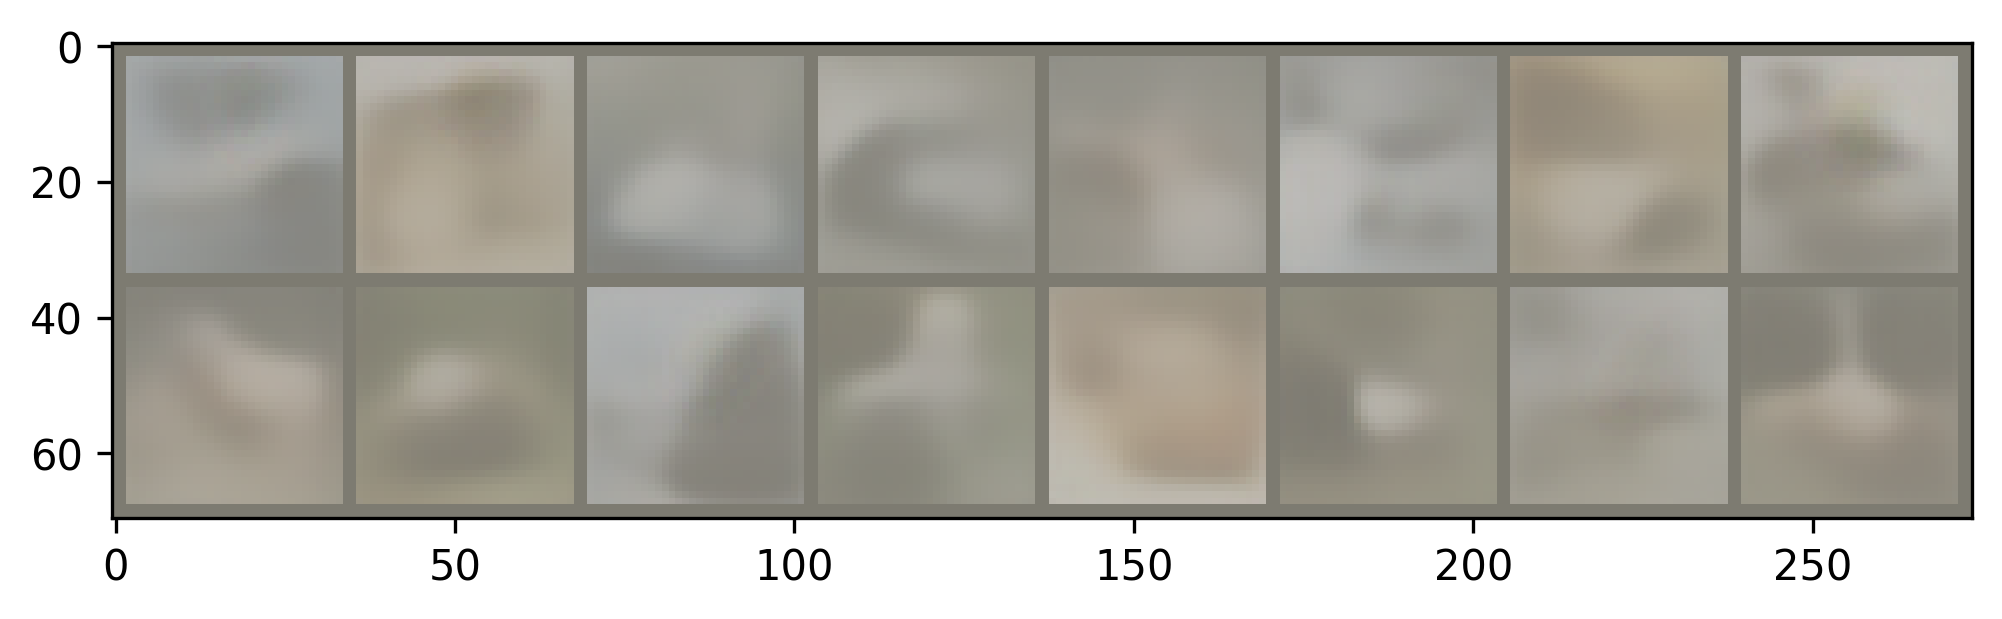

In [13]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);